# Objective

To apply generalized eigendecomposition to maximize the contrast between conditions. GED gives us a spatial filter that is optimized to capture differences induced in beta frequency power between intensity levels 

In [2]:
import mne, numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, eig

## Load data

In [3]:
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


In [4]:
%matplotlib inline

Reading /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/sub22_ses00_final-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


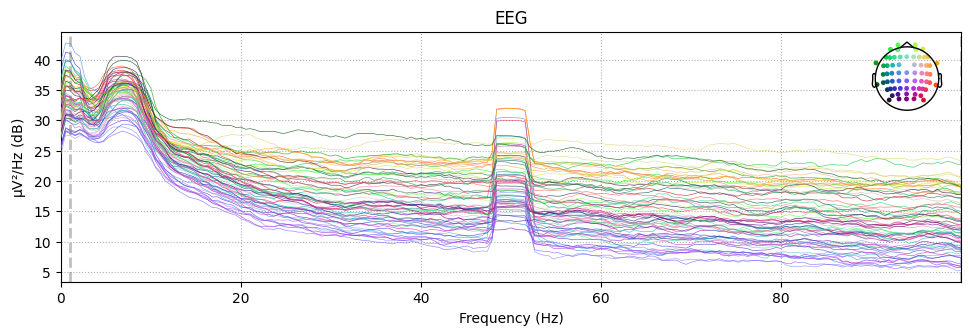

In [5]:
this_ses = 'sub22_ses00_final'

fdir = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/'
base_epochs = mne.read_epochs(fdir+this_ses+'-epo.fif')

# going to first calculate the psd for each trial (per channel) and then average the psds

base_epochs_psd = base_epochs.compute_psd(fmax=100)

base_epochs_psd.plot();

In [124]:
# Getting time series for beta filtered

base_epochs_beta_filt = base_epochs.copy().filter(l_freq=4, h_freq=10)
beta_filt_dat = base_epochs_beta_filt.get_data()
no_filt_dat = base_epochs.get_data()

Setting up band-pass filter from 4 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1664 out of 1664 | elapsed:    1.0s finished


In [8]:
t = base_epochs.get_data()
t.shape

(26, 64, 1901)

In [13]:
t[0][:5].shape

(5, 1901)

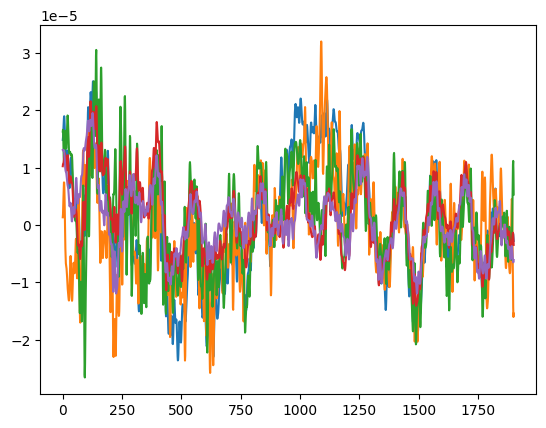

In [14]:
plt.plot(t[0][:5].T);

In [16]:
t[0].mean(axis=1).shape

(64,)

In [ ]:
tt = t.copy()
tt[0]

In [17]:
def GED_cov_avg(cond_epoch, ref_epoch, return_norm_vecs=True):
    # will generate covariance mat for each trial and then average to then apply GED
    cond_dat = cond_epoch.get_data()
    ref_dat = red_epoch.get_data()
    
    trs, chs, tpoints = cond_dat.shape
    
    
    # initializing average cov matrices
    cond_cov = np.zeros((chs, chs))
    ref_cov = np.zeros((chs, chs))

    for tr in range(trs): 

        # demean first
        cond_tr = cond_tr - cond_tr.mean(axis=1)
        ref_tr = ref_tr - ref_tr.mean(axis=1)
        
        # add up cov mats
        cond_cov += cond_tr @ cond_tr.T
        ref_cov += ref_tr @ ref_tr.T


    cond_cov = cond_cov/len(cond_cov)
    ref_cov = ref_cov/len(ref_cov)

    vals, vecs = eig(a=cond_cov, b=ref_cov)
    
    if return_norm_vecs:
        norm_vecs = np.zeros_like(vecs)
        for n, vec in enumerate(vecs):
            norm_vecs[n] = vec/np.linalg.norm(vec)
        return vals, norm_vecs
    else:
        return vals, vecs

In [18]:
def GED_trs_ts_avg(cond_epoch, ref_epoch, return_norm_vecs=True):
    # will generate one trial by averaging the time series of all trials and then  apply GED
    cond_dat = cond_epoch.average().get_data()
    ref_dat = red_epoch.average().get_data()
    
    chs, tpoints = cond_dat.shape
    
    # demean first
    cond_dat = cond_dat - cond_dat.mean(axis=1)
    ref_dat = ref_dat - ref_dat.mean(axis=1)

    # add up cov mats
    cond_cov += cond_dat @ cond_dat.T
    ref_cov += ref_dat @ ref_dat.T

    vals, vecs = eig(a=cond_cov, b=ref_cov)
    
    if return_norm_vecs:
        norm_vecs = np.zeros_like(vecs)
        for n, vec in enumerate(vecs):
            norm_vecs[n] = vec/np.linalg.norm(vec)
        return vals, norm_vecs
    else:
        return vals, vecs

In [125]:
# # will generate GED filter for each trial and then average components


# trs, chs, tpoints = beta_filt_dat.shape
# components_per_trial = np.zeros((trs, chs))

# for tr in range(trs):
#     cond_dat = beta_filt_dat[tr]
#     ref_dat = no_filt_dat[tr]
#     # data already demeaned
#     cond_cov = cond_dat @ cond_dat.T
#     ref_cov = ref_dat @ ref_dat.T
#     vals, vecs = eig(a=cond_cov, b=ref_cov)
#     top_vec = vecs[0].copy()
#     top_vec = top_vec/np.linalg.norm(top_vec)
#     components_per_trial[tr] = top_vec


/tmp/ipykernel_24320/193123929.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  components_per_trial[tr] = top_vec


In [150]:
# will generate GED filter for each trial and then average components


trs, chs, tpoints = beta_filt_dat.shape
components_per_trial = np.zeros((trs, chs))

#calculating reference average first (averaging cov mats). Actually doing both for cond and ref.
cond_cov = np.zeros((chs, chs))
ref_cov = np.zeros((chs, chs))

for tr in range(trs):
    ref_dat = no_filt_dat[tr]
    ref_cov += ref_dat @ ref_dat.T

    cond_dat = beta_filt_dat[tr]    
    # data already demeaned
    cond_cov += cond_dat @ cond_dat.T

cond_cov = cond_cov/len(cond_cov)
ref_cov = ref_cov/len(ref_cov)

vals, vecs = eig(a=cond_cov, b=ref_cov)
top_vec = vecs[0].copy()
top_vec = top_vec/np.linalg.norm(top_vec)
components_per_trial[tr] = top_vec


/tmp/ipykernel_24320/548086380.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  components_per_trial[tr] = top_vec


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


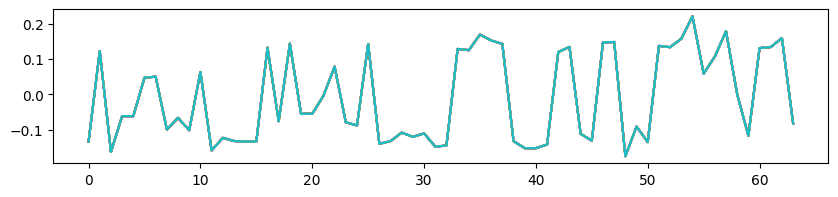

In [152]:
# now I want to see how they look like
fig, ax = plt.subplots(figsize=(10, 2))
for tr in range(10):
#     ax.scatter(x=np.arange(0, 64), y=components_per_trial[tr])
    ax.plot(np.arange(0, 64), top_vec)

In [154]:
avg_spat_filt = top_vec.copy()

/tmp/ipykernel_24320/2393313040.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(epochs.ch_names, rotation=90);


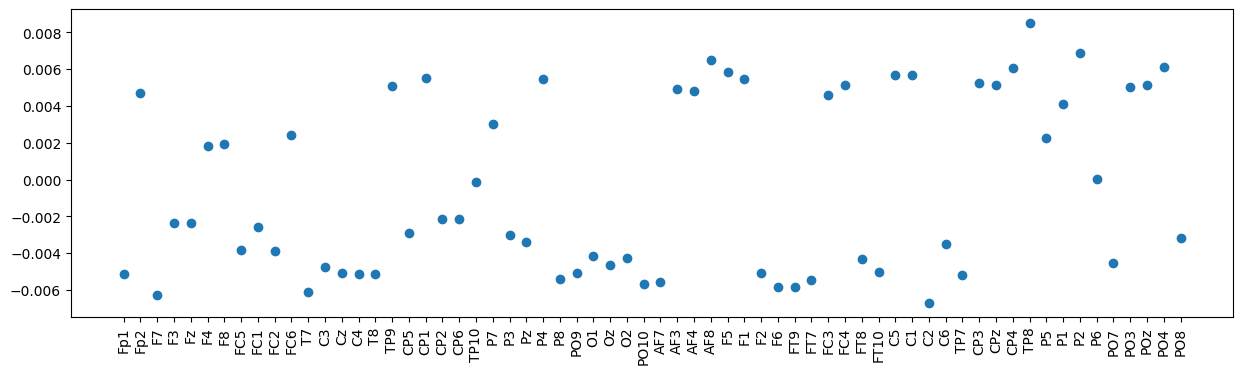

In [155]:
avg_spat_filt = components_per_trial.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=epochs.ch_names, y=avg_spat_filt)
ax.set_xticklabels(epochs.ch_names, rotation=90);

In [156]:
avg_spat_filt[np.argsort(avg_spat_filt)]

array([-6.72374388e-03, -6.24252279e-03, -6.09059936e-03, -5.84338822e-03,
       -5.83829173e-03, -5.66719033e-03, -5.56268940e-03, -5.44579406e-03,
       -5.37302835e-03, -5.18317590e-03, -5.12724985e-03, -5.11552046e-03,
       -5.11552046e-03, -5.08592049e-03, -5.07428784e-03, -5.06336245e-03,
       -5.02853052e-03, -4.72207427e-03, -4.61254908e-03, -4.50255247e-03,
       -4.28641632e-03, -4.24063055e-03, -4.15179197e-03, -3.89173175e-03,
       -3.80974763e-03, -3.48756385e-03, -3.37616328e-03, -3.15409811e-03,
       -3.02629317e-03, -2.91451080e-03, -2.54962088e-03, -2.36186493e-03,
       -2.36186493e-03, -2.11024252e-03, -2.11024252e-03, -1.43195162e-04,
        1.00504330e-05,  1.82200868e-03,  1.92560489e-03,  2.26185950e-03,
        2.43634586e-03,  3.01945646e-03,  4.11710220e-03,  4.60345808e-03,
        4.71719798e-03,  4.80807183e-03,  4.94388314e-03,  5.03431858e-03,
        5.08321100e-03,  5.13218814e-03,  5.14759759e-03,  5.16198654e-03,
        5.27626584e-03,  

In [157]:
np.array(epochs.ch_names)[np.argsort(avg_spat_filt)]

array(['C2', 'F7', 'T7', 'FT9', 'F6', 'PO10', 'AF7', 'FT7', 'P8', 'TP7',
       'Fp1', 'C4', 'T8', 'F2', 'PO9', 'Cz', 'FT10', 'C3', 'Oz', 'PO7',
       'FT8', 'O2', 'O1', 'FC2', 'FC5', 'C6', 'Pz', 'PO8', 'P3', 'CP5',
       'FC1', 'F3', 'Fz', 'CP2', 'CP6', 'TP10', 'P6', 'F4', 'F8', 'P5',
       'FC6', 'P7', 'P1', 'FC3', 'Fp2', 'AF4', 'AF3', 'PO3', 'TP9', 'CPz',
       'POz', 'FC4', 'CP3', 'P4', 'F1', 'CP1', 'C5', 'C1', 'F5', 'CP4',
       'PO4', 'AF8', 'P2', 'TP8'], dtype='<U4')

In [158]:
avg_spat_filt.shape

(64,)

/tmp/ipykernel_24320/2798641434.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(epochs.ch_names)[np.argsort(avg_spat_filt)], rotation=90);


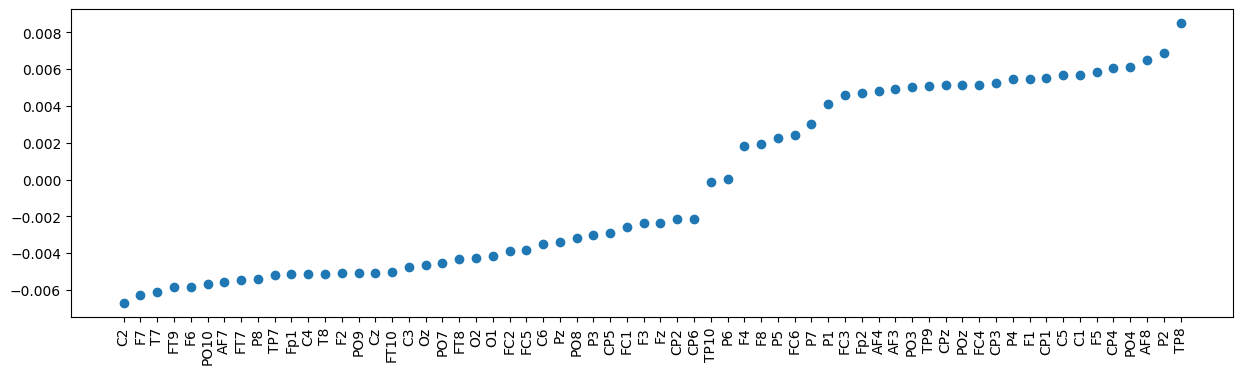

In [159]:
avg_spat_filt = components_per_trial.mean(axis=0)
fig, ax = plt.subplots(figsize=(15, 4))
ax.scatter(x=np.array(epochs.ch_names)[np.argsort(avg_spat_filt)], y=avg_spat_filt[np.argsort(avg_spat_filt)])
ax.set_xticklabels(np.array(epochs.ch_names)[np.argsort(avg_spat_filt)], rotation=90);

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


(0.0, 45.0)

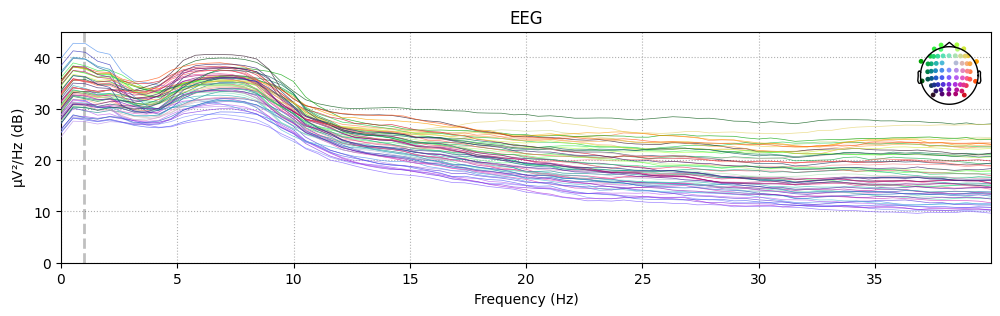

In [160]:
fig, ax = plt.subplots(figsize=(12,3))
base_epochs.copy().compute_psd(fmax=40).plot(axes=ax);
ax.set_ylim(0, 45)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


(0.0, 45.0)

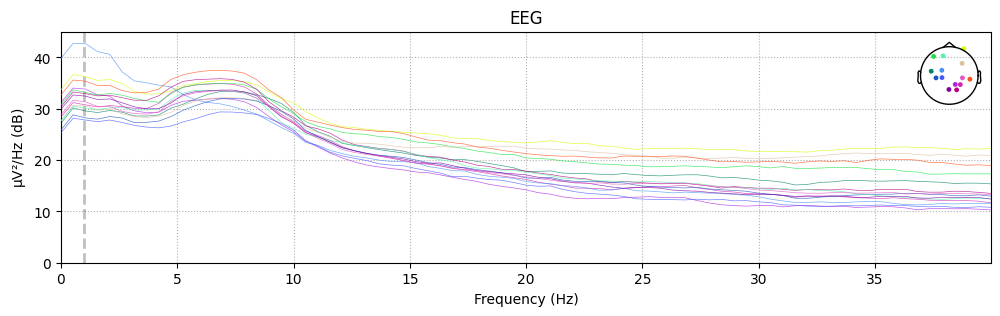

In [166]:
fig, ax = plt.subplots(figsize=(12,3))
base_epochs.copy().pick_channels(['PO4', 'AF8', 'P2', 'TP8', 'POz', 'FC4', 'CP3', 'P4', 'F1', 'CP1', 'C5', 'C1', 'F5', 'CP4']).compute_psd(fmax=40).plot(axes=ax);
ax.set_ylim(0, 45)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


(0.0, 45.0)

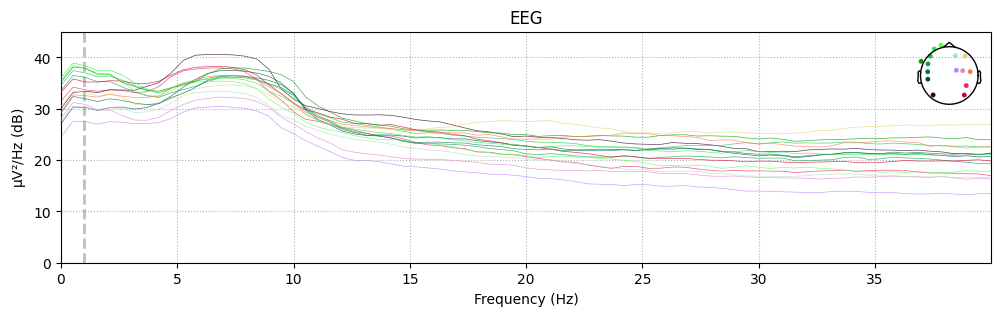

In [167]:
fig, ax = plt.subplots(figsize=(12,3))
base_epochs.copy().pick_channels(['C2', 'F7', 'T7', 'FT9', 'F6', 'PO10', 'AF7', 'FT7', 'P8', 'TP7',
       'Fp1', 'C4', 'T8', 'F2', 'PO9',]).compute_psd(fmax=40).plot(axes=ax);
ax.set_ylim(0, 45)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


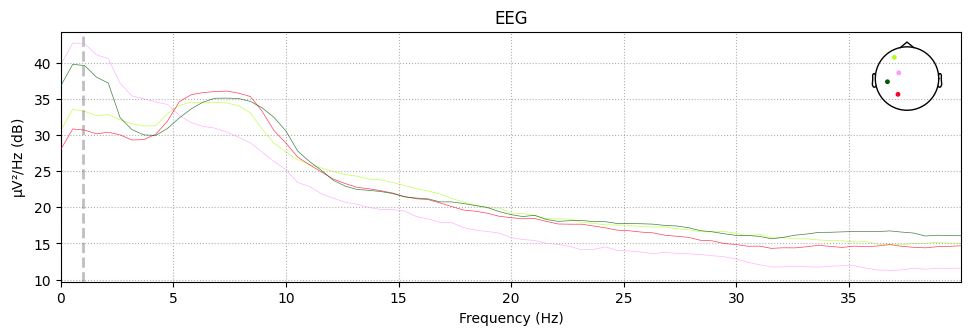

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Need more than one channel to make topography for eeg. Disabling interactivity.


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


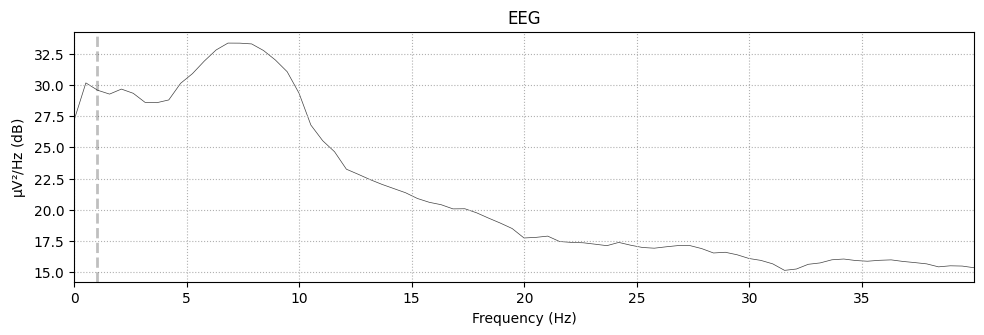

In [120]:
base_epochs.copy().pick_channels(['C5']).compute_psd(fmax=40).plot();

In [106]:
np.argsort(avg_spat_filt)

array([ 3, 42, 31, 60, 58, 55, 11,  4, 52, 53, 28, 12, 19,  0, 25, 20, 43,
       26, 61, 59, 39, 18, 40,  6, 21,  7, 48, 51, 29, 50, 56,  8, 22, 33,
        9, 15,  5, 24, 36, 35, 13, 27, 54,  2, 14, 10, 30, 37, 47, 63, 23,
       57, 34, 62, 16, 32,  1, 49, 17, 44, 38, 41, 45, 46])

In [107]:
base_epochs.info['sfreq']

1000.0

/tmp/ipykernel_24320/411834877.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  rearranged_data[tr] = top_vec @ no_filt_dat[tr]


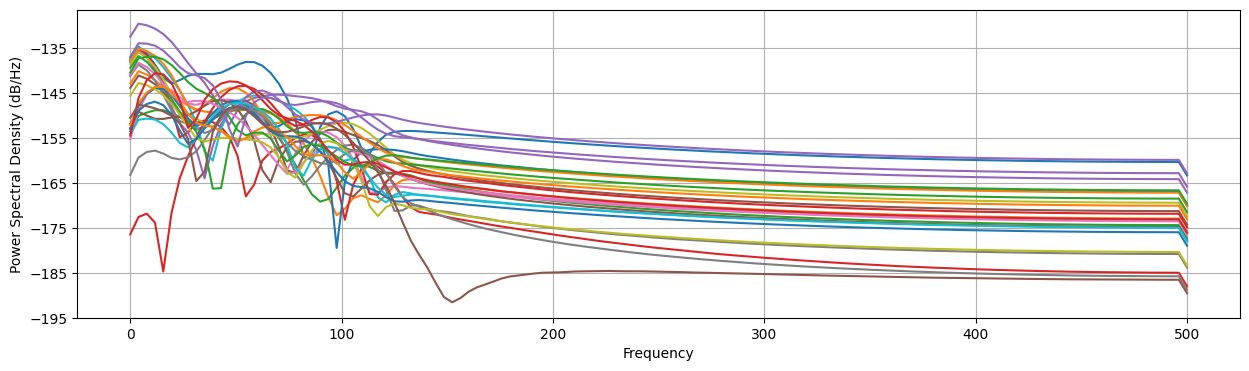

In [108]:
rearranged_data = np.zeros_like(no_filt_dat)
fig, ax = plt.subplots(figsize=(15,4))
for tr in range(trs):
    rearranged_data[tr] = top_vec @ no_filt_dat[tr]
    ax.psd(rearranged_data[tr], Fs=1000, )

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


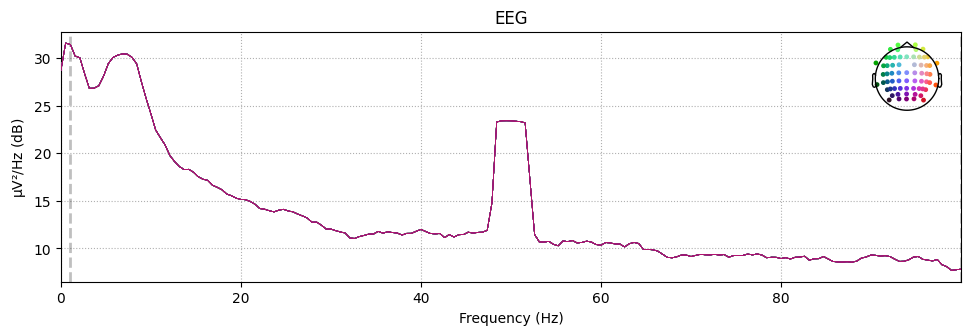

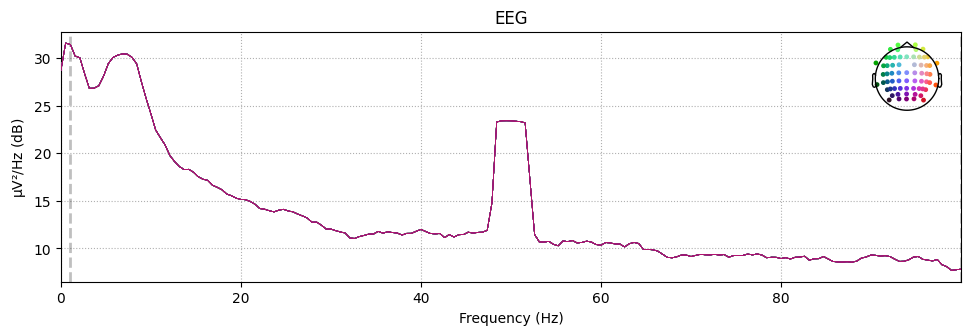

In [109]:
new_epochs = mne.EpochsArray(rearranged_data, base_epochs.info)
new_epochs.copy().compute_psd(fmax=100).plot()

In [ ]:
def find_most_sensitive(cond_epochs, ref_epochs):
    

In [110]:
_cond_dat = beta_filt_dat[0]
_ref_dat = no_filt_dat[0]
_cond_dat.shape

(64, 1901)

/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


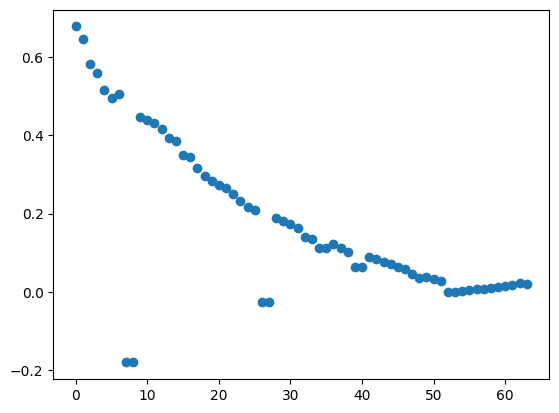

In [38]:
_cond_cov = _cond_dat @ _cond_dat.T
_ref_cov = _ref_dat @ _ref_dat.T
_vals, _vecs = eig(a=_cond_cov, b=_ref_cov)
plt.scatter(x=np.arange(0, len(_vals)), y=_vals)

In [39]:
_vecs[0].shape

(64,)

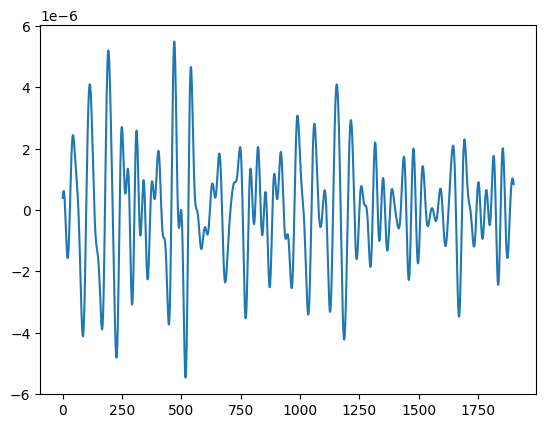

In [33]:
plt.plot(t[0])

Reading /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/sub22_ses01_final-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


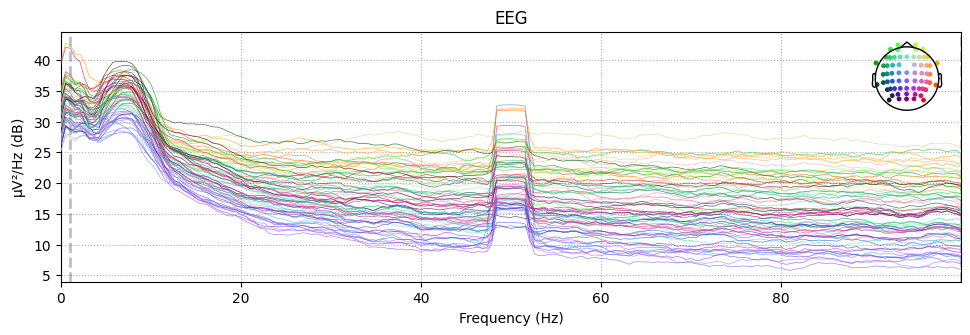

In [14]:
this_ses = 'sub22_ses01_final'

fdir = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/'
epochs = mne.read_epochs(fdir+this_ses+'-epo.fif')
epochs_psd = epochs.compute_psd(fmax=100)
epochs_psd.plot();

Reading /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/sub22_ses10_final-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1800.00 ms
        0 CTF compensation matrices available
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


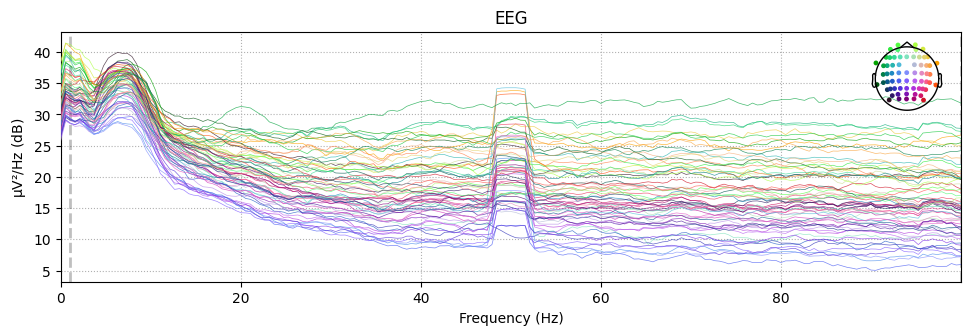

In [16]:
this_ses = 'sub22_ses10_final'

fdir = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/bme1500/preprocessed/'
epochs = mne.read_epochs(fdir+this_ses+'-epo.fif')
epochs_psd = epochs.compute_psd(fmax=100)
epochs_psd.plot();

    Using multitaper spectrum estimation with 7 DPSS windows


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


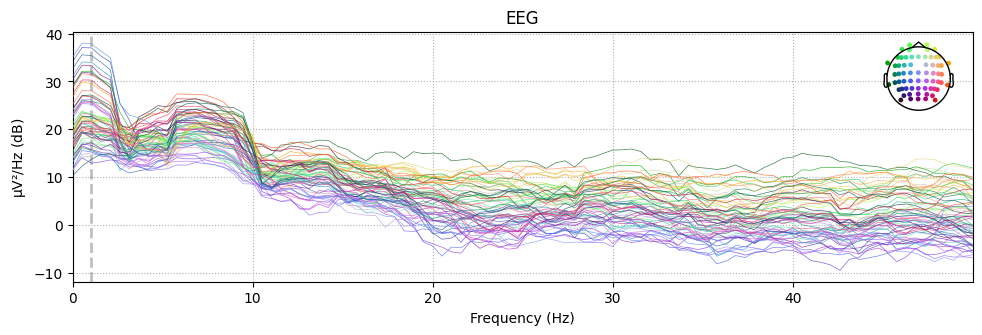

In [9]:
evoked.compute_psd(fmax=50).plot()

In [10]:
t = epochs.get_data()

In [6]:
t.shape

(28, 64, 9501)

In [7]:
tz = np.zeros((64, 9501*28))
tz.shape

(64, 266028)

In [14]:
# def conc_trials(epochs):
#     ep_dat = epochs.get_data()
#     trs = ep_dat.shape[0]
#     chs = ep_dat.shape[1]
#     tpoints =  ep_dat.shape[2]
#     concd = np.zeros((chs, trs*tpoints))
#     for ch in range(chs):
#         for tr in range(trs):
#             concd[ch][tr*tpoints:(tr+1)*tpoints] = ep_dat[tr][ch]
#     return concd

In [15]:
conc = conc_trials(epochs)

In [28]:
inf = mne.create_info(epochs.ch_names, 5000, ch_types='eeg')

In [31]:
inf = epochs.info
inf

<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 5000.0 Hz
 subject_info: 1 item (dict)
>

In [33]:
psu_raw = mne.io.RawArray(conc, inf)

Creating RawArray with float64 data, n_channels=64, n_times=266028
    Range : 0 ... 266027 =      0.000 ...    53.205 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.051 (s)


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


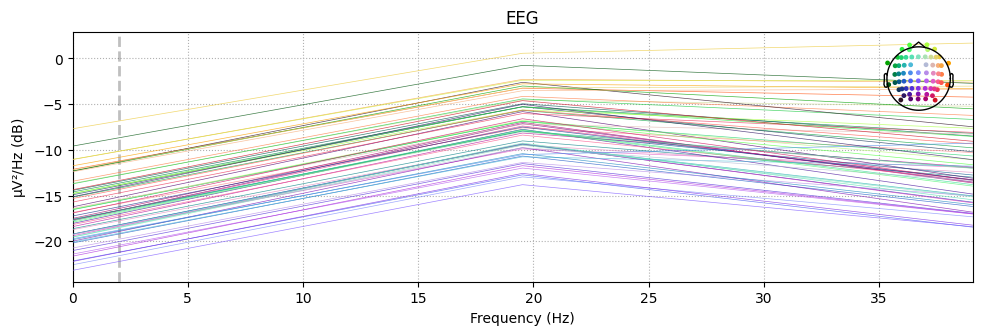

In [34]:
psu_raw.plot_psd(fmax=40);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.560 (s)


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


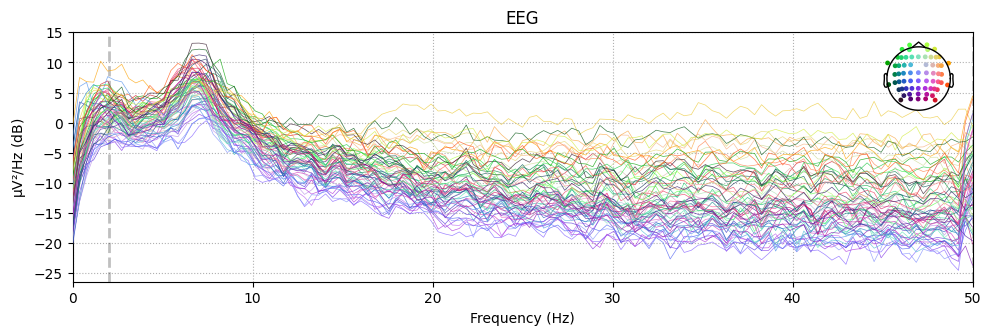

In [36]:
psu_raw.copy().resample(100).plot_psd(fmax=50);

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


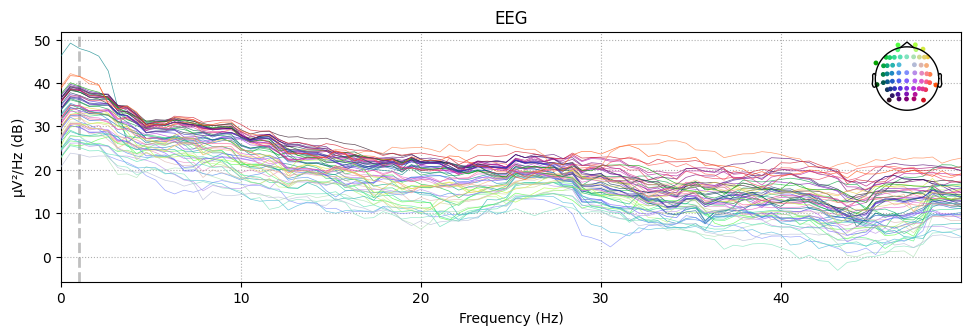

In [13]:
evoked.plot_psd(fmax=50);

## Get covariance matrices

### Test condition

Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


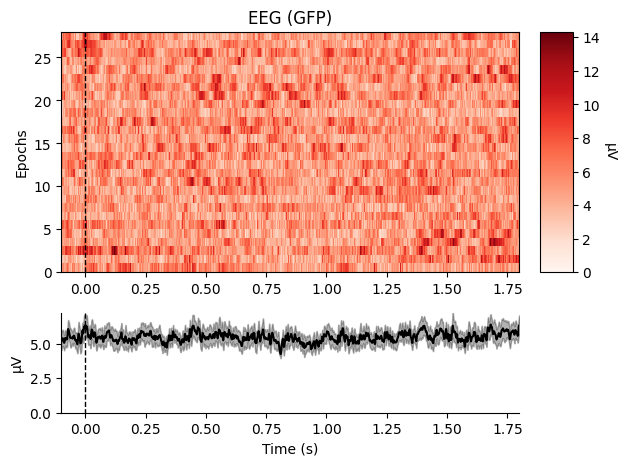

In [39]:
epochs.plot_image();

In [114]:
# condition is data at the beta frequency band.
beta_evoked = psu_raw.copy().filter(l_freq=12.5, h_freq=30)
beta_evoked_dat = beta_evoked.get_data()
beta_evoked_dat.shape

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.50
- Lower transition bandwidth: 3.12 Hz (-6 dB cutoff frequency: 10.94 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 5281 samples (1.056 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.1s finished


(60, 9501)

In [136]:
mn = beta_evoked_dat.mean(axis=1)
mn = np.tile(mn, (9501, 1))
mn = np.moveaxis(mn, (0,1), (1,0))

In [137]:
mn.shape

(60, 9501)

In [131]:
np.tile(mn, (9501, 1))

array([[-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09],
       [-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09],
       [-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09],
       ...,
       [-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09],
       [-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09],
       [-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, ...,
        -4.18613532e-10,  4.72786548e-10, -1.62196989e-09]])

In [130]:
mn

array([-9.19342788e-10, -2.89835923e-09,  4.36441506e-10, -1.01995523e-09,
       -1.00239808e-09, -5.65645470e-10,  1.53517599e-09, -1.30410062e-09,
        1.35615593e-10, -3.39967565e-10,  1.10452460e-09,  1.16310537e-09,
        6.91697978e-11, -7.80558890e-10, -5.34325024e-10,  1.05604323e-08,
        2.70786699e-09, -1.31961084e-09,  4.44545516e-10,  1.02190722e-09,
        2.31423975e-09,  6.25696992e-09, -7.71053628e-10, -6.57832826e-10,
        9.66058981e-10,  1.16547338e-09,  6.05475624e-09,  1.50311340e-09,
       -1.68694155e-09, -1.71462807e-09, -2.88102287e-09, -8.81216218e-10,
        5.04180240e-10,  9.64853891e-10,  1.19523059e-09,  7.59981689e-11,
       -3.38875645e-10,  4.44940014e-10,  7.09048365e-10, -2.87606269e-10,
       -1.16714441e-10, -3.17450030e-10, -1.17351163e-09,  1.86522127e-09,
        1.66477401e-09, -3.01497909e-10,  2.25447235e-09,  1.70708289e-09,
       -8.31209366e-10,  1.49350981e-09,  1.54739010e-09,  8.21773561e-09,
       -1.00517570e-09,  

In [138]:
# make sure the average of each channel is zero
dm = beta_evoked_dat - mn
dm.shape

(60, 9501)

In [139]:
dm.mean(axis=1)

array([ 1.31944928e-23, -1.06982374e-24, -3.56607914e-25, -5.88403058e-24,
       -3.74438309e-24,  9.27180576e-24, -2.85286331e-24, -1.35511007e-23,
       -2.31795144e-24,  5.70572662e-24, -2.85286331e-24,  1.56907482e-23,
       -9.98502159e-24,  7.13215828e-25, -5.70572662e-24,  5.70572662e-24,
        7.13215828e-25,  8.55858993e-24, -1.42643166e-24, -1.17680612e-23,
        7.48876619e-24,  1.49775324e-23, -1.14114532e-23,  0.00000000e+00,
        7.84537410e-24,  8.55858993e-24, -4.27929497e-24, -5.70572662e-24,
       -1.42643166e-24, -8.55858993e-24, -2.13964748e-23, -1.14114532e-23,
        7.13215828e-24, -7.13215828e-25, -1.06982374e-23,  2.31795144e-24,
       -3.56607914e-25, -8.20198202e-24, -1.56907482e-23, -1.06982374e-23,
       -3.20947122e-24,  6.41894245e-24, -8.91519785e-25,  1.28378849e-23,
        9.45010972e-24,  1.42643166e-24, -1.06982374e-24, -1.56907482e-23,
       -2.28229065e-23,  1.06982374e-24, -4.99251079e-24,  7.84537410e-24,
       -7.84537410e-24,  

In [115]:
cond_cov = beta_evoked_dat @ beta_evoked_dat.T
cond_cov.sum()

5.770868156565851e-06

In [86]:
# should I be doing this?
cond_cov = cond_cov - cond_cov.mean()
cond_cov.sum()

-8.999725064576941e-22

In [87]:
cond_cov.mean()

-2.4999236290491503e-25

### Reference

Reference could be:
 - baseline with no DBS at beta range
 - broadband signal with the same DBS intensity
 - Beta range of other intensity conditions?
 
Not sure which one is the best

In [22]:
evoked_dat = evoked.get_data()

In [23]:
# here I'm going with broadband of same file
ref_cov = evoked_dat @ evoked_dat.T
ref_cov = ref_cov - ref_cov.mean()
ref_cov.shape

(60, 60)

In [88]:
ref_cov.mean()

1.3999819984675057e-08

In [89]:
# GED
vals, vecs = eigh(a=cond_cov, b=ref_cov)

In [90]:
vecs.shape

(60, 60)

In [ ]:
# normalize eigenvectors by dividing by norm: v =  v/norm(v)

In [96]:
np.max(np.abs(vals))

8317284541532.26

In [99]:
vecs[0]

array([-4.68732098e+10,  2.81909206e+09,  3.48257902e+06, -5.82134137e+08,
        5.88288733e+08,  7.89481352e+08, -8.07235151e+08,  6.28844292e+08,
       -1.72220789e+09,  4.34203414e+08,  6.06695816e+09,  2.68471478e+09,
       -1.70607760e+10,  1.14229137e+09,  9.39904187e+08,  2.79921768e+08,
        2.05625132e+09,  4.09236701e+09,  1.43641250e+09, -1.89638225e+09,
        1.75856909e+08,  1.75183877e+09, -9.53669479e+08, -1.15534722e+09,
        1.59598757e+09, -1.86206560e+09, -2.36715863e+09,  9.27787611e+09,
       -4.66595353e+09,  5.45038946e+09,  3.63170224e+09, -4.58866048e+09,
       -1.25194394e+09,  8.89072113e+08, -7.20407777e+08,  6.83889448e+08,
        8.02229556e+08,  7.83593573e+08,  7.37127422e+08,  1.38225897e+07,
       -4.54597895e+08, -2.76772578e+08, -1.67340203e+07, -2.44661572e+07,
        3.81060792e+08,  1.16773702e+09, -6.21982564e+08, -1.01282577e+09,
        1.01114246e+08,  2.49830854e+08,  4.03950030e+08, -2.90168007e+08,
       -7.10630186e+07, -

In [98]:
np.where(np.abs(vals)==np.abs(vals).max())

(array([0]),)

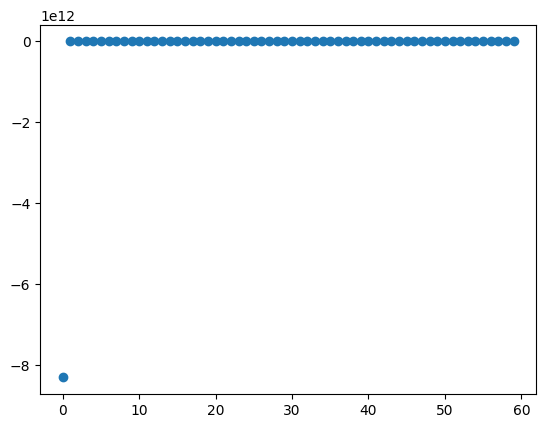

In [111]:
plt.scatter(x=np.arange(0,60), y=vals)

In [37]:
# new_evoked_dat = vecs @ evoked_dat
# new_evoked = mne.EvokedArray(new_evoked_dat, evoked.info)

In [38]:
# new_evoked_dat.shape

In [39]:
# new_evoked.plot_psd(fmax=50);

In [100]:
top_vec = vecs[0] * -1 # to make positive

In [101]:
max_comp = top_vec @ evoked_dat

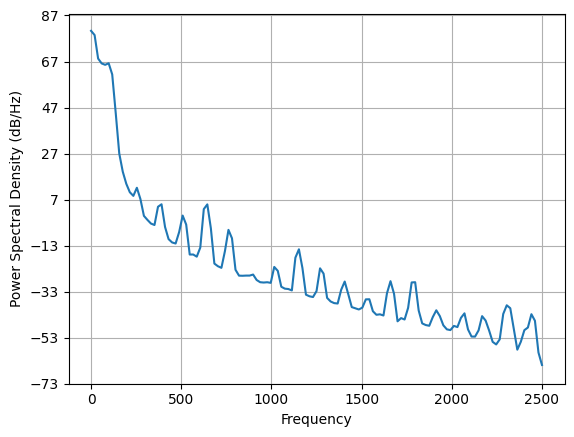

In [102]:
plt.psd(max_comp, Fs=5000);

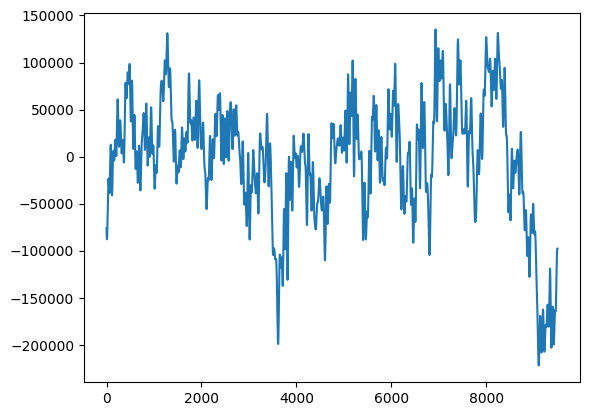

In [103]:
plt.plot(max_comp)

In [62]:
from scipy import signal

In [59]:
sf = 5000
freqs, psd = signal.windows.dpss(100,sf,nperseg=1000)

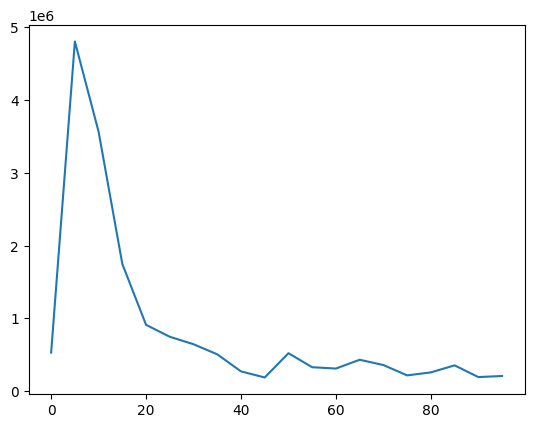

In [60]:
plt.plot(freqs[:20],psd[:20])

In [104]:
ev = mne.EvokedArray(max_comp[np.newaxis, :], mne.create_info(['max_comp'], 5000))

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_29160/1783940301.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  ev.plot_psd(fmax=50, picks=['misc']);
/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


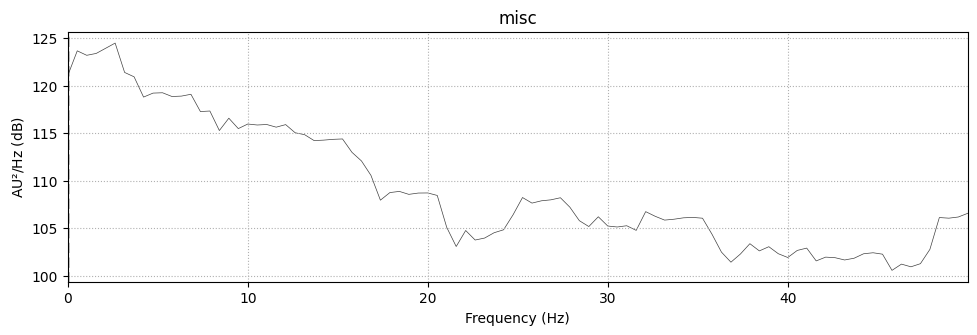

In [105]:
ev.plot_psd(fmax=50, picks=['misc']);

In [106]:
# sanity check
t = evoked_dat.mean(axis=0)
t.shape

(9501,)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_29160/3124486047.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  tt.plot_psd(fmax=50, picks=['misc']);
/external/rprshnas01/kcni/moveisi/envs/course/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


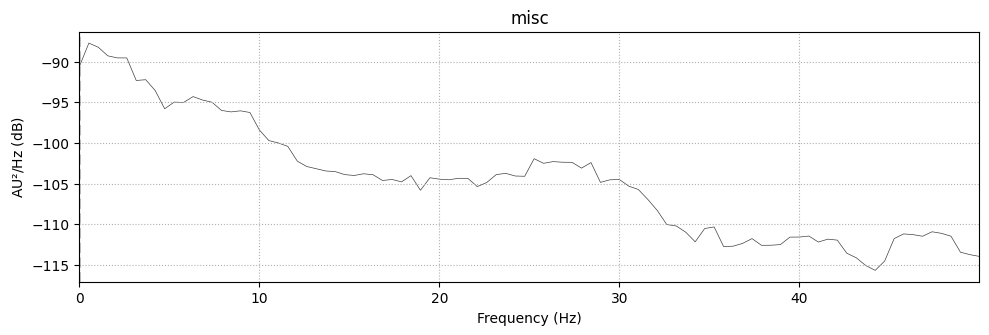

In [107]:
tt = mne.EvokedArray(t[np.newaxis, :], mne.create_info(['max_comp'], 5000))
tt.plot_psd(fmax=50, picks=['misc']);